<a href="https://colab.research.google.com/github/raultinajeroo/NLP-Machine-Learning-Analysis/blob/main/source.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤖 ***Machine Learning Project*** 
**Los Mineros:** Aaron Cardiel & Raul Tinajero


---



<a name="Introduction"></a>
# ***Introduction***


In this study of Machine Learning models we'll make an analysis of the natural language processing capabilities of different types of models. We'll do so through the understanding of the disaster tweets datasets, which provide tweet data with the aim of determining if any given tweet is disaster related or not. We approach this task by utilizing TF-IDF in the preprocessing of data, and training and testing a variety of models with that preprocessed data, said models are: Logistic Regression, Random Forest, Support Vector Machines, Naïve Bayes, and two Convolutional Neural Networks. We also apply error visualization techniques to selected models in order to learn from the outcome of such training and improve upon the results. 



---



# ***Index***
1.   [**Introduction**](#Introduction)
2.   **Preparation**
  * [Libraries](#Libraries)
  * [Data Visualization](#Visualization)
  * [Data Preprocessing](#Preprocessing)
3.  **Models**
  * [Logistic Regression](#Introduction)
  * [Random Forest](#Introduction)
  * [Suppor Vector Machines](#Introduction)
  * [Naïve Bayes](#Introduction)
  * [Model 5: Convolutional Neural Network (One-Hot Encoded Location and Keyword Features)](#C)
  * [Models](#Introduction)
4.   [**Final Results**](#Results)
5.   [**Conclusion**](#Conclusion)



---




<a name="Preparation"></a>
# ***Preparation***

<a name="Libraries"></a>
## *Libraries*

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import re

from matplotlib import pyplot as plt
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Input, Conv1D, GlobalMaxPooling1D, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model



## *Data + Method Set-up*

In [ ]:
import os
for csv_file in ['train.csv', 'test.csv', 'sample_submission.csv']: # Avoids Re-run
  if not os.path.isfile(csv_file):
    from google.colab import files
    files.upload()

In [ ]:
train_data = pd.read_csv("train.csv")
X_test = pd.read_csv("test.csv")

X_train = train_data.iloc[:, :-1] # X is all columns but last
Y_train = train_data.iloc[:, -1] # Y is only 'target' column
X_train, X_train_val, Y_train, Y_train_val = train_test_split(X_train, Y_train, test_size=.1, train_size=.9, random_state=100)

print(f"Training count: {len(X_train)}")
print(f"Validation count: {len(X_train_val)}")
print(f"Test count: {len(X_test)}")

Training count: 6851
Validation count: 762
Test count: 3263


### *create_csv()*
Create CSV File for easy kaggle submission

In [ ]:
def create_csv(prediction, file_name='submission'):
  df = pd.DataFrame()
  df['id'] = X_test['id']
  df['target'] = prediction
  df.to_csv(f'{file_name}.csv', index=False)

### *visualize_errors()*
Make for simple error visualization for all models

In [ ]:
def prob_to_class(Y_pred_prob, threshold):
  if len(Y_pred_prob.shape) == 1:
    return (Y_pred_prob >= threshold).astype(int)
  else:
    return (Y_pred_prob[:, 1] >= threshold).astype(int)


def visualize_errors(Y_true, Y_pred_prob, threshold, e_num=10, only_cm=False):
  # Convert probability predictions to class predictions
  Y_pred = prob_to_class(Y_pred_prob, threshold)

  # Create a simple 2x2 confusion matrix for with Actual / Predicted Labels
  print("CONFUSION MATRIX:")
  cm = pd.crosstab(Y_true, Y_pred, rownames=['Actual'], colnames=['Pred'])
  cm.style
  display(cm)

  if not only_cm:
    print("\nERRORS:")  # Get all error's information for display
    error_df = pd.DataFrame()
    mask = Y_true != Y_pred

    error_df['Index'] = X_train_val[mask].index
    error_df['Actual'] = Y_true[mask].values
    error_df['Pred'] = Y_pred[mask]

    if len(Y_pred_prob.shape) != 1:
      error_indices = np.where(mask)[0]  # Get the indices where mask is True
      error_df['Difference'] = np.abs(Y_pred_prob[error_indices, 1] - Y_true.iloc[error_indices].values)  # Calculate the difference between actual values and predicted probabilities using .iloc

    error_df['Text'] = X_train_val[mask]['text'].values

    pd.set_option('display.max_colwidth', None)  # Display all of the text
    if len(Y_pred_prob.shape) != 1:
      error_df = error_df.sort_values(by=['Difference'], ascending=False)

    # Display a set number of error examples
    error_df.style
    display(error_df.head(e_num))


### *score()*
Calculate and output training and validation F1 scores

In [ ]:
from sklearn.metrics import f1_score
def score(model, X_t=X_train, X_v=X_train_val, predict=True): # For testing before submission
  if predict:
    X_t = model.predict(X_t)
    X_v = model.predict(X_v)
  train_score = f1_score(Y_train, X_t)
  val_score = f1_score(Y_train_val, X_v)
  print(f'Training accuracy: {train_score:.4f}')
  print(f'Validation accuracy: {val_score:.4f}')

In [ ]:
from sklearn.metrics import f1_score
def probability_score(model, threshold, X_tr=None, X_v=None):
  if X_tr is None or X_v is None:
    X_tr, X_v, X_te = preprocess_data(X_train, X_train_val, X_test)
  Y_t = model.predict_proba(X_tr)
  Y_v = model.predict_proba(X_v)

  train_score = f1_score(Y_train, prob_to_class(Y_t, threshold))
  val_score = f1_score(Y_train_val, prob_to_class(Y_v, threshold))
  print(f'Training accuracy: {train_score:.4f}')
  print(f'Validation accuracy: {val_score:.4f}')

<a name="Visualization"></a>
## *Data Visualization*

**Analyze keywords for both disaster and non-disaster tweets:**

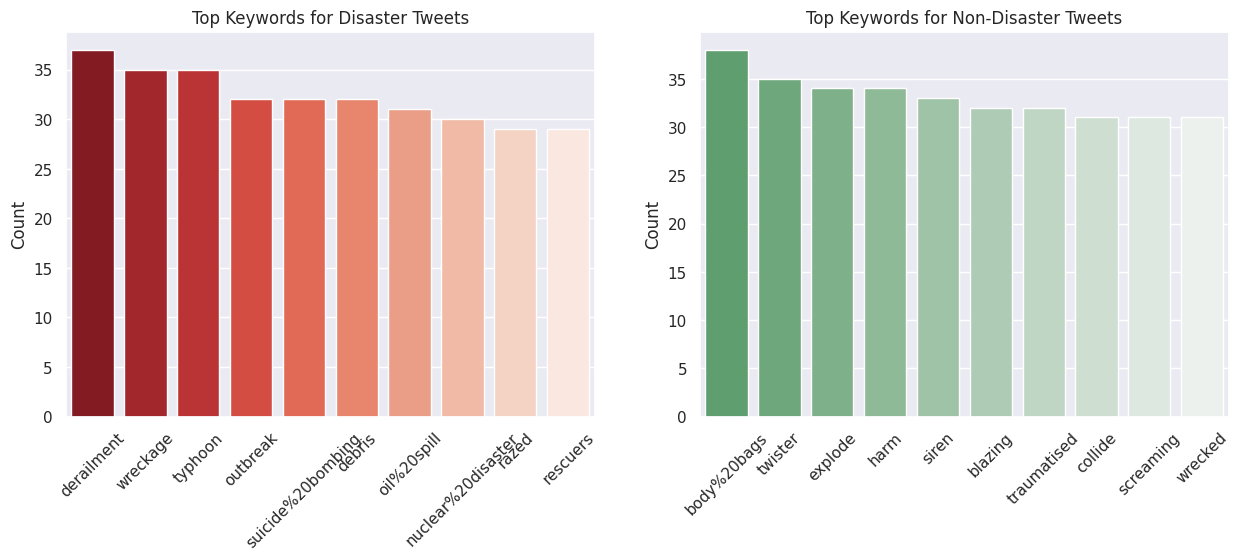

In [ ]:
keywords_disaster = X_train[Y_train == 1]['keyword'].value_counts().head(10)
keywords_non_disaster = X_train[Y_train == 0]['keyword'].value_counts().head(10)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=keywords_disaster.index, y=keywords_disaster, palette='Reds_r')
plt.title('Top Keywords for Disaster Tweets')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x=keywords_non_disaster.index, y=keywords_non_disaster, palette='light:g_r')
plt.title('Top Keywords for Non-Disaster Tweets')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.show()

**Analyze hashtags for both disaster and non-disaster tweets:**

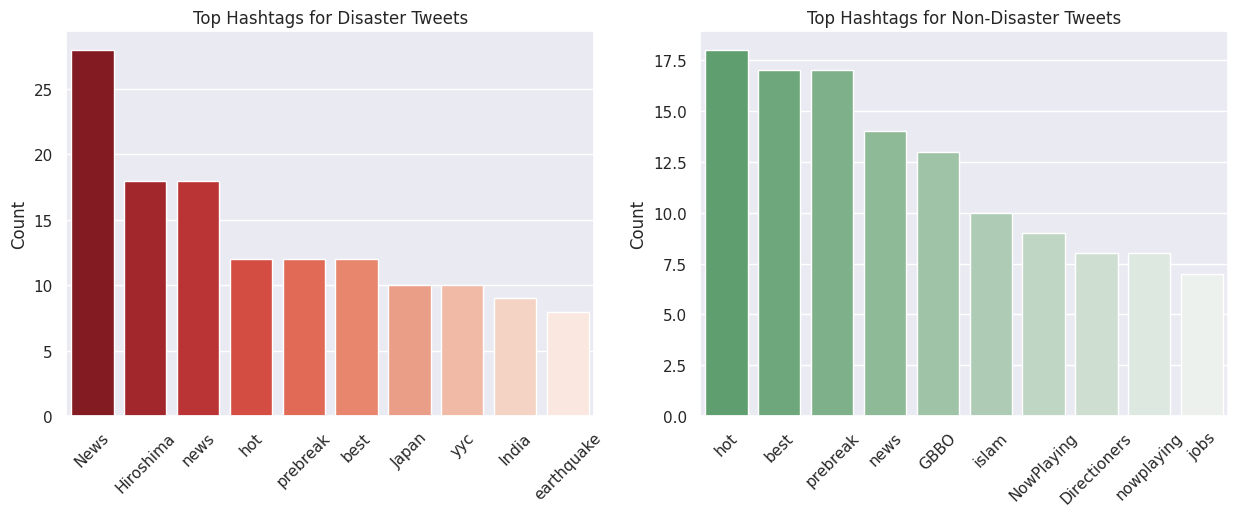

In [ ]:
def get_hashtags(tweet): # Get all words with a '#' before them; hashtags
    return re.findall(r'#(\w+)', tweet) # Finds words with '#' but avoids passing off the '#'

hashtags_disaster = pd.Series([hashtag for hashtags in X_train[Y_train == 1]['text'].apply(get_hashtags) for hashtag in hashtags]).value_counts().head(10)
hashtags_non_disaster = pd.Series([hashtag for hashtags in X_train[Y_train == 0]['text'].apply(get_hashtags) for hashtag in hashtags]).value_counts().head(10)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=hashtags_disaster.index, y=hashtags_disaster, palette='Reds_r')
plt.title('Top Hashtags for Disaster Tweets')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x=hashtags_non_disaster.index, y=hashtags_non_disaster, palette='light:g_r')
plt.title('Top Hashtags for Non-Disaster Tweets')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.show()

**Analyzing data based on location:**

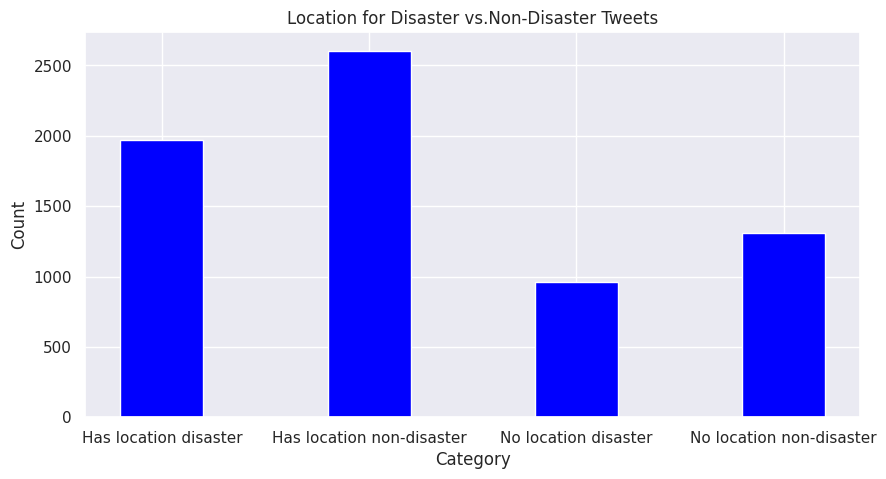

In [ ]:
#Getting count of all disaster/non-disaster tweets that don't have location
no_location_disaster_count = X_train[Y_train == 1]['location'].isna().sum()
no_location_non_disaster_count = X_train[Y_train == 0]['location'].isna().sum()

#Getting count of all disaster/non-disaster tweets that have a location
location_disaster_count = X_train[Y_train == 1]['location'].count()
location_non_disaster_count = X_train[Y_train == 0]['location'].count()

location_data = {'Has location disaster': location_disaster_count, 'Has location non-disaster': location_non_disaster_count, 'No location disaster': no_location_disaster_count, 'No location non-disaster': no_location_non_disaster_count}
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(location_data.keys(), location_data.values(), color ='blue', width = 0.4)
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Location for Disaster vs.Non-Disaster Tweets")
plt.show()

**Analyzing data based on keyword**

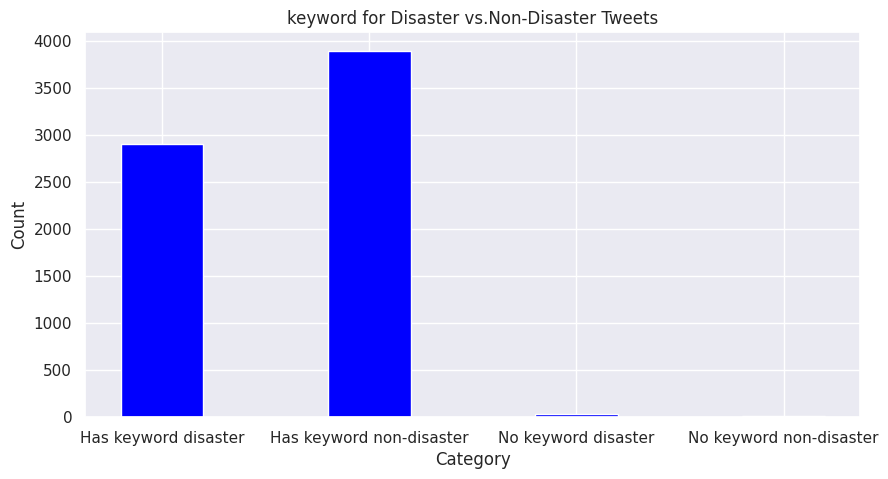

In [ ]:
#Getting count of all disaster/non-disaster tweets that don't have keyword
no_keyword_disaster_count = X_train[Y_train == 1]['keyword'].isna().sum()
no_keyword_non_disaster_count = X_train[Y_train == 0]['keyword'].isna().sum()

#Getting count of all disaster/non-disaster tweets that have a keyword
keyword_disaster_count = X_train[Y_train == 1]['keyword'].count()
keyword_non_disaster_count = X_train[Y_train == 0]['keyword'].count()

keyword_data = {'Has keyword disaster': keyword_disaster_count, 'Has keyword non-disaster': keyword_non_disaster_count, 'No keyword disaster': no_keyword_disaster_count, 'No keyword non-disaster': no_keyword_non_disaster_count}
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(keyword_data.keys(), keyword_data.values(), color ='blue', width = 0.4)
 
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("keyword for Disaster vs.Non-Disaster Tweets")
plt.show()

<a name="Preprocessing"></a>
## Data Preprocessing
From testing it was found that ['text'] is the only reliable feature within the training and testing data. Which is why it's the only one kept for the models to learn from.

In [ ]:
!pip install contractions
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import contractions
import copy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 11.7 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def clean_text(text: str):
  text = str(text) # Helps make sure our input is in string format
  text = re.sub(r'http\S+|@\S+|[^a-zA-Z\s]', '', text) # Remove URLs, tags, and special characters
  text = text.lower() # Convert text to lowercase
  contractions.fix(text) # Fix contractions ("you're" to "you are", etc)
  return word_tokenize(text) # Tokenizes sentences into a list of separate words and returns that list


def preprocess_data(X_train, X_train_val, X_test):
  # Deep copy dataframes to avoid modifying the original data
  X_tr = copy.deepcopy(X_train)
  X_v = copy.deepcopy(X_train_val)
  X_te = copy.deepcopy(X_test)

  # Clean text data
  X_tr['text'] = X_train['text'].apply(clean_text)
  X_v['text'] = X_train_val['text'].apply(clean_text)
  X_te['text'] = X_test['text'].apply(clean_text)

  # Vectorize data using TF-IDF
  vectorizer = TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x)
  X_tr = vectorizer.fit_transform(X_tr['text'])
  X_v = vectorizer.transform(X_v['text'])
  X_te = vectorizer.transform(X_te['text'])

  return X_tr, X_v, X_te

In [ ]:
X_tr, X_v, X_te = preprocess_data(X_train, X_train_val, X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


> Although we considered pre-processing at this step to make the data be prepared from the start, doing so would've affected the behavior of models 1.1 and 1.2 which played a key role in our early application of data preprocessing.

<a name="Models"></a>
# ***Models***

<a name="Introduction"></a>
### ***Baseline***

This baseline model uses DummyRegressor, to make constant predictions of 0 for all input data. It's designed to compare against the more advanced models in this document.

In [ ]:
from sklearn.dummy import DummyRegressor
baseline = DummyRegressor(strategy='constant', constant=0) # Creates a baseline prediction of 0 for all tweets
baseline.fit(X_train, Y_train)

Y_pred = baseline.predict(X_test)

In [ ]:
score(baseline) # Baseline evaluation on validation data

Training accuracy: 0.0000
Validation accuracy: 0.0000


Kaggle Test Score:

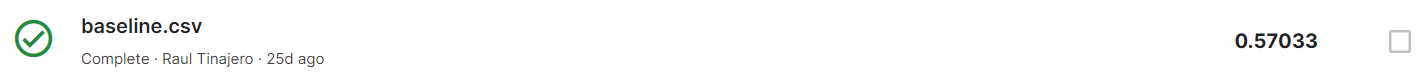

<a name="LR"></a>
### ***Model 1: Logistic Regression***
Logistic Regression is a good model for this project as it performs well with binary classification problems.

In [ ]:
from sklearn.linear_model import LogisticRegression

#### **Model Versions**

##### *1.1. Just Text*
In this code only the text data is turned into a numerical format to be passed through our simple Logistic Regression Model. This model uses the default loss function for Logistic Regression: Log Loss. This is an appropriate application because it serves to measure the performance of the classification model by penalizing high confidence wrong predictions.

In [ ]:
vectorizer = TfidfVectorizer()

X_train_vectorized = vectorizer.fit_transform(X_train['text'])
X_train_val_vectorized = vectorizer.transform(X_train_val['text'])

Model1_1 = LogisticRegression()

Model1_1.fit(X_train_vectorized, Y_train)

score(Model1_1, X_train_vectorized, X_train_val_vectorized)

Training accuracy: 0.8549
Validation accuracy: 0.7638


##### *1.2. Combine all features*
In this code we made the change to using all of the data provided and turning it into a numerical format to be passed through our simple Logistic Regression Model. This model uses the default loss function for Logistic Regression: Log Loss.

In [ ]:
vectorizer = TfidfVectorizer()
Model1_2 = LogisticRegression()

def combine_features1_2(X):
  X['combined_text'] = X['keyword'].fillna('') + ' ' + X['location'].fillna('') + ' ' + X['text']

combine_features1_2(X_train)
combine_features1_2(X_train_val)

X_train_vectorized = vectorizer.fit_transform(X_train['combined_text'])
X_train_val_vectorized = vectorizer.transform(X_train_val['combined_text'])

Model1_2.fit(X_train_vectorized, Y_train)

score(Model1_2, X_train_vectorized, X_train_val_vectorized)

Training accuracy: 0.8556
Validation accuracy: 0.7607


##### *1.3. Using Data Preprocessing*
In this code we made the change to using our data preprocessing model, from the previous models we started developing this idea, but here is where you can really see the comparison of simple vectorization vs our [preprocess_data() method](#Preprocess)

In [ ]:
Model1_3 = LogisticRegression()

Model1_3.fit(X_tr, Y_train)

score(Model1_3, X_tr, X_v)

Training accuracy: 0.8548
Validation accuracy: 0.7680


In [ ]:
Y_v_pred_prob = Model1_3.predict_proba(X_v)

# Convert probabilities to class predictions
Y_v_pred = np.argmax(Y_v_pred_prob, axis=1)

#### **Error Analysis**

In [ ]:
# Select model to represent Logarithmic Regression
M1 = Model1_3

In [ ]:
# Call visualize errors to get an idea of what's going wrong with our model
visualize_errors(Y_train_val, M1.predict_proba(X_v), 0.46)

CONFUSION MATRIX:


Pred,0,1
Actual,,
0,374,53
1,87,248



ERRORS:


,Index,Actual,Pred,Difference,Text
39,7203,1,0,0.914288,Even if u have your weapon and your badge we gonna put them choppas on your ass????
81,4444,1,0,0.902350,I went to pick up my lunch today and the bartender was holding my change hostage because he wanted my number. ??
103,6108,1,0,0.891823,Do you feel like you are sinking in low self-image? Take the quiz: http://t.co/bJoJVM0pjX http://t.co/wHOc7LHb5F
77,5441,0,1,0.862555,Police expand search for missing pregnant woman in Beloeil: Police in Richelieu-Saint-Laurent are expanding th... http://t.co/hMuyzmv8qH
36,5068,1,0,0.857573,Of course the one day I have to dress professionally aka unsensibly for class is the day I have try and outrun a natural disaster!
108,3992,1,0,0.855810,@Cyberdemon531 i hope that mountain dew erodes your throat and floods your lungs leaving you to drown to death
109,2556,1,0,0.843389,@Beyonce @NicoleKidman @Oprah these money grubbing kikes need to get a clueI have no money but I can still destroy with telekinesis. Watch.
138,1080,1,0,0.811595,If I fall is men GOD @Praiz8 is d bomb well av always known dat since 2008 bigger u I pray sir
20,4055,0,1,0.810176,Tales of the #trees #deep water loving #Lake Tahoe. And no #forest fires https://t.co/xuhMJ098Lq
76,819,1,0,0.801244,@Ashayo @MsMiggi Hi Ashayo! I believe there will be VODs on YouTube after the presentation but there is nothing like seeing it live :)


**Analysis:**
*   False Negatives, A=1 - P=0,  are over 2.5 more likely to occur than False Positives, indicating our model is more likely to qualify Disasters as Non-disasters than vice versa. This can be addressed by changing our threshold, data resampling, changing to a weighted-loss function, or more extensive feature engineering.



##### *Fixes*
1. class_weight='balanced': By using a balanced class weight our model is forced to pay more attention to the minority class, leading to less FN. While FP did increase, our overall score got better.
2. predict_proba: By utilizing probability prediction instead of class prediction we can manipulate the threshold to fit our false negatives issue.

In [ ]:
M1_1 = LogisticRegression(class_weight='balanced')
M1_1.fit(X_tr, Y_train)
score(M1_1, X_tr, X_v)
visualize_errors(Y_train_val, M1_1.predict_proba(X_v), 0.46, only_cm=True)

Training accuracy: 0.8734
Validation accuracy: 0.7771
CONFUSION MATRIX:


Pred,0,1
Actual,,
0,342,85
1,74,261


In [ ]:
M1_2 = LogisticRegression()
M1_2.fit(X_tr, Y_train)
probability_score(M1_2, 0.46)
visualize_errors(Y_train_val, M1_2.predict_proba(X_v), 0.46, only_cm=True)

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Training accuracy: 0.8702
Validation accuracy: 0.7799
CONFUSION MATRIX:


Pred,0,1
Actual,,
0,374,53
1,87,248


#### **Results**

In [ ]:
Y_pred = prob_to_class(M1_2.predict_proba(X_te), 0.46)
create_csv(Y_pred, 'sub1')

Kaggle Test Score:

 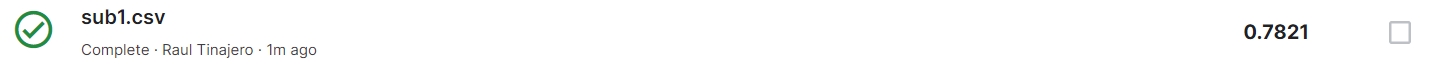

<a name="RF"></a>
### ***Model 2: Random Forest***

Here, we employ a Random Forest Classifier, a model that works by constructing multiple decision trees and outputting the class that is the mode among all the trees, making it a great model for our project. This model uses Gini Impurity Criterion as its default loss function, which works great for classification problems like this one.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#### **Model Versions**
From Logistic Regression we learned the benefit of probability prediction over class prediction, which is why we'll continue the same here.

##### *2.1. Class Prediction*

In [ ]:
Model2_1 = RandomForestClassifier()
Model2_1.fit(X_tr, Y_train)
score(Model2_1, X_tr, X_v)

##### *2.2. Probability Prediction*

In [ ]:
Model2_2 = RandomForestClassifier()
Model2_2.fit(X_tr, Y_train)
probability_score(Model2_2, .47)

#### *Parameter Tests*
| n_estimators | max_features | max_depth | Training Accuracy | Validation Accuracy |
| :-: | :-: | :-: | :-: | :-: |
|     |     |     | .9863 | .7547 |
| 100 |     |     | .9863 | .7504 |
| 200 |     |     | .9863 | .7377 |
| 100 | 0.3 |     | .9863 | .7453 |
| 100 | 0.3 |  5  | .5072 | .4885 |

#### **Error Analysis**

In [ ]:
# Select model to represent Logarithmic Regression
M2 = Model2_2

In [ ]:
# Call visualize errors to get an idea of what's going wrong with our model
visualize_errors(Y_train_val, M2.predict_proba(X_v), 0.47)

**Analysis:**
*   Overfitting: The model is clearly overfitting with a training accuracy of 0.9863, but a validation accuracy of just 0.7547. This can be addressed by playing around with RandomForest's parameters, and implementing cross-validation.
*   False Negatives, A=1 - P=0,  are over 2x as likely to occur than False Positives, indicating our model is more likely to qualify Disasters as Non-disasters than vice versa. This can be addressed by changing our threshold, data resampling, or more extensive feature engineering.
*   High Confidence: The model seems too have high confidence in incorrect results. Some ways to address this issue could be to fine-tune some of the model's hyperparameters. Ensembling might also be a useful approach that could potentially improve the generalization of the model as well.



#### **Results**

In [ ]:
Y_pred = M2.predict(X_te)
create_csv(Y_pred, 'sub2')

Kaggle Test Score: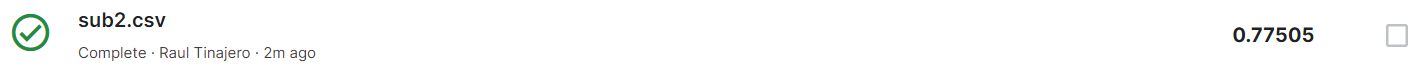

<a name="SVC"></a>
### ***Model 3: Support Vector Machines***

In [ ]:
from sklearn.svm import SVC

#### **Model Versions**

##### *3.1. Linear Kernel*
In this code, we use a Support Vector Machine with a linear kernel to classify the tweet data. The SVM uses the default loss function for classification, which is the hinge loss. The linear kernel is used to transform the data into a linearly separable space, which can help with binary classification problems.

In [ ]:
Model3_1 = SVC(kernel='linear', probability=True) 
Model3_1.fit(X_tr, Y_train)

In [ ]:
probability_score(Model3_1, 0.43)

##### *3.2. RBF*
In this code, a Support Vector Machine (SVM) model with a Radial Basis Function (RBF) kernel is used to classify whether a given tweet is about an actual disaster or not. The RBF kernel is appropriate for this model as it can handle non-linearly separable data. The SVM model aims to maximize the margin between the two classes, which is useful for our binary classification problem.

In [ ]:
Model3_2 = SVC(kernel='rbf', probability=True)
Model3_2.fit(X_tr, Y_train)

In [ ]:
probability_score(Model3_2, 0.43)

#### **Error Analysis**

In [ ]:
# Select model to represent Logarithmic Regression
M3 = Model3_1

In [ ]:
# Call visualize errors to get an idea of what's going wrong with our model
visualize_errors(Y_train_val, M3.predict_proba(X_v), 0.43)

**Analysis:**
*   Though the amount of False Negatives and Positives within these models is somewhat equal, it does not take away from the sheer quantity present within the confusion matrix. A possible to address this is to apply some advanced tokenization techniques that could specify on twitter.



#### **Results**

In [ ]:
Y_pred = M3.predict(X_te)
create_csv(Y_pred, 'sub3')

Kaggle Test Score: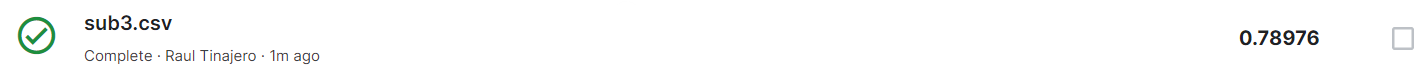

<a name="NB"></a>
### ***Model 4: Naïve Bayes***

In [ ]:
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB

#### **Model Versions**

##### *4.1. Multinomial Naïve Bayes*
Here we employ MNB, this model is a great choice as it is simple, and efficient. MNB uses the negative log-likelihood loss function, this is appropriate as its primarily used for probabilistic classification as seen with this problem.

In [ ]:
Model4_1 = MultinomialNB()
Model4_1.fit(X_tr.toarray(), Y_train)
probability_score(Model4_1, 0.34, X_tr, X_v)

##### *4.2. Bernoulli Naïve Bayes*
Here we apply BNB. This model is one of the best choices for this task as performs great in classifcation problems with binary features. Another great point about this model is its modeling of presence and absence of words in the text. BNB uses the negative log-likelihood loss function, this is appropriate as its primarily used for probabilistic classification as seen with this problem.

In [ ]:
Model4_2 = BernoulliNB()
Model4_2.fit(X_tr.toarray(), Y_train)
probability_score(Model4_2, 0.49, X_tr, X_v)

##### *4.3. Complement Naïve Bayes*
Here we employ a CNB. CNB is an adaptation of MNB that is particularly well suited for imbalanced data sets. Though our dataset itself is not inbalanced, our results for a large portion of our tests are. As all our other models, CNB utilizes negative log likelihood loss.

In [ ]:
Model4_3 = ComplementNB()
Model4_3.fit(X_tr.toarray(), Y_train)
probability_score(Model4_3, 0.43)

#### **Error Analysis**

In [ ]:
# Select model to represent Logarithmic Regression
M4 = Model4_2

In [ ]:
# Call visualize errors to get an idea of what's going wrong with our model
visualize_errors(Y_train_val, M4.predict_proba(X_v), 0.47)

**Analysis:**
*   False Negatives, A=1 - P=0,  are over 2x as likely to occur than False Positives, indicating our model is more likely to qualify Disasters as Non-disasters than vice versa. This can be addressed by changing our threshold, data resampling, or more extensive feature engineering.
*   Ambiguity: Some of these tweets may actually be incorrectly classified, leading to the model making some mistakes. (e.g., Indexes 6108, and 4444). A possible way to address this is through some extensive feature engineering.



#### **Results**

In [ ]:
Y_pred = M4.predict(X_te)
create_csv(Y_pred, 'sub4')

Kaggle Test Score: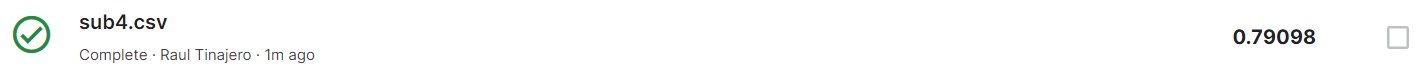

<a name="CNN1"></a>
### ***Model 5: Convolutional Neural Network (One-Hot Encoded Location and Keyword Features)***



**Description**

The code defines a function called CNN_preprocess_data() that preprocesses the training data by tokenizing the text data, padding the sequences to have a fixed length, and one-hot encoding the categorical variables. It then combines the text and categorical data and pads it to a fixed shape. The build_model() function preprocesses the training data using the CNN_preprocess_data() function and then defines a convolutional neural network (CNN) model with an input layer, embedding layer, convolutional layer, pooling layer, dense layer, dropout layer, and output layer. It compiles the model using binary cross-entropy loss and the Adam optimizer, and then trains the model on the preprocessed training data using three epochs and a batch size of 32. Finally, it returns the trained model. 

#### **Model Versions**

##### *5.1 One-Hot Encoded Location and Keyword Features*

In [ ]:
def CNN_preprocess_data(training_data, tokenizer, max_sequence_length, fixed_shape):
    X = training_data.copy()

    # Tokenize the text data
    sequences = tokenizer.texts_to_sequences(X['text'])
    word_index = tokenizer.word_index

    # Pad sequences to have a fixed length
    data = pad_sequences(sequences, maxlen=max_sequence_length)

    # One-hot encode the categorical variables
    location_one_hot = pd.get_dummies(X['location']).values
    keyword_one_hot = pd.get_dummies(X['keyword']).values

    # Combine text and categorical data
    X_processed = np.concatenate((data, location_one_hot, keyword_one_hot), axis=1)

    # Add the correct length of the data
    X_processed = X_processed[:, :max_sequence_length + len(location_one_hot[0]) + len(keyword_one_hot[0])]

    # Pad to fixed shape
    X_processed = np.pad(X_processed, ((0, 0), (0, fixed_shape - X_processed.shape[1])), mode='constant')

    return X_processed

def build_model(X_train, Y_train, tokenizer, max_sequence_length, fixed_shape):
    # Preprocess training data
    X_train_processed = CNN_preprocess_data(X_train, tokenizer, max_sequence_length, fixed_shape)

    # Define model architecture with fixed input shape
    embedding_dim = 50
    input_layer = Input(shape=(fixed_shape, ))

    embedding_layer = Embedding(len(tokenizer.word_index) + 1, embedding_dim)(input_layer)
    conv_layer = Conv1D(filters=32, kernel_size=3, activation='relu')(embedding_layer)
    pooling_layer = GlobalMaxPooling1D()(conv_layer)
    dense_layer_1 = Dense(32, activation='relu')(pooling_layer)
    dropout_layer = Dropout(0.9)(dense_layer_1) #Mitigates overfitting
    output_layer = Dense(1, activation='sigmoid')(dropout_layer)
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    model.fit(X_train_processed, Y_train, epochs=3, batch_size=32, validation_split=0.2)

    return model

# Train the model
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['text'])
max_sequence_length = 50
fixed_shape = max_sequence_length + X_train['location'].nunique() + X_train['keyword'].nunique() + 1
model_5 = build_model(X_train, Y_train, tokenizer, max_sequence_length, fixed_shape)

#### **Model Evaluation**

In [ ]:
# Preprocess training and validation data. Predicts probabilities and sets values to 1 or 0 based on the threshold of .5
X_train_tokenized = CNN_preprocess_data(X_train, tokenizer, max_sequence_length, fixed_shape)
train_prediction = model_5.predict(X_train_tokenized)
train_prediction_binary = (train_prediction >= .5).astype(int)

X_train_val_tokenized = CNN_preprocess_data(X_train_val, tokenizer, max_sequence_length, fixed_shape)
val_train_prediction = model_5.predict(X_train_val_tokenized)
val_train_prediction_binary = (val_train_prediction >= .5).astype(int)

#Scores the training and validation predictions based on F1 metric
score(model_5, train_prediction_binary, val_train_prediction_binary, predict=False)

#### **Error Analysis**

In [ ]:
# Call visualize errors to get an idea of what's going wrong with our model
visualize_errors(Y_train_val, model_5.predict(X_train_val_tokenized).reshape(762,), .47)

**Analysis:**
*   The False Negatives and False Positive ratio is actually very close to 1:1 although we get more False Negatives.
*  Overall pretty well balanced in the ratio.



##### *Fixes*





*   Overall, this model tends to get too good at memorizing the training data quickly because of its small size and the optimizer used. To fix this and make it perform better on new data, we can shrink the layers and adjust them, and also add drop-out layers to the model to prevent overfitting. And to get the best results, we'll keep the number of training cycles limited.



#### **Results**

In [ ]:
# Preprocess test data
X_test_tokenized = CNN_preprocess_data(X_test, tokenizer, max_sequence_length, fixed_shape)

# Make predictions on test data
X_test_prediction = model_5.predict(X_test_tokenized)
X_test_prediction_binary = (X_test_prediction >= .5).astype(int)
create_csv(X_test_prediction_binary, 'sub5')

Kaggle Test Score:
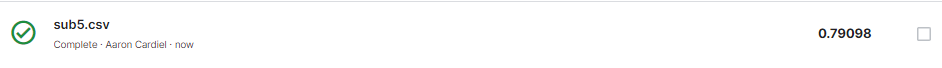



<a name="CNN1"></a>
### ***Model 6: Convolutional Neural-Network (Weighted Location and Keyword Features)***


**Description**

The code represents a function CNN_preprocess_data() that preprocesses the training data for a convolutional neural network (CNN) by tokenizing the text data, padding sequences to have a fixed length, and replacing the location and keyword columns with their corresponding weighted representations. The weights are calculated by dividing the count of each location/keyword by the total number of location/keyword entries, respectively. These weighted representations are concatenated with the text data and the resulting matrix is padded to a fixed shape. The build_model() function then defines the architecture of the CNN with an embedding layer, a 1D convolutional layer, a global max pooling layer, two dense layers, and an output layer. The model is compiled with binary crossentropy loss, Adam optimizer with learning rate 0.001, and accuracy metric. Finally, the model is trained on the preprocessed data for 2 epochs with a batch size of 32 and validation split of 0.3. The weighted location and keyword data are important because they provide additional categorical information to the CNN, which can improve its accuracy in predicting the target variable.

#### **Model Versions**

##### *6.1 Weighted Location and Keyword Features*

In [ ]:
def CNN_preprocess_data(training_data, tokenizer, max_sequence_length, fixed_shape):
    X = training_data.copy()

    # Tokenize the text data
    sequences = tokenizer.texts_to_sequences(X['text'])
    word_index = tokenizer.word_index

    # Pad sequences to have a fixed length
    data = pad_sequences(sequences, maxlen=max_sequence_length)

    # Convert the location and keyword columns to lists of strings
    location_list = X['location'].tolist()
    keyword_list = X['keyword'].tolist()

    # Assign a weight to each entry in location and keywords
    location_weights = {}
    for loc in location_list:
        if loc in location_weights:
            location_weights[loc] += 1
        else:
            location_weights[loc] = 1
    location_weights = {k: v/len(location_list) for k, v in location_weights.items()}

    keyword_weights = {}
    for kw in keyword_list:
        if kw in keyword_weights:
            keyword_weights[kw] += 1
        else:
            keyword_weights[kw] = 1
    keyword_weights = {k: v/len(keyword_list) for k, v in keyword_weights.items()}

    # Replace location and keyword columns with weighted representations
    location_weighted = []
    for loc in location_list:
        location_weighted.append(location_weights[loc])
    keyword_weighted = []
    for kw in keyword_list:
        keyword_weighted.append(keyword_weights[kw])

    # Combine text and categorical data
    X_processed = np.concatenate((data, np.array(location_weighted)[:, np.newaxis], np.array(keyword_weighted)[:, np.newaxis]), axis=1)

    # Add the correct length of the data
    X_processed = X_processed[:, :max_sequence_length + 2]

    # Pad to fixed shape
    X_processed = np.pad(X_processed, ((0, 0), (0, fixed_shape - X_processed.shape[1])), mode='constant')

    return X_processed


def build_model(X_train, Y_train, tokenizer, max_sequence_length, fixed_shape):
    # Preprocess training data
    X_train_processed = CNN_preprocess_data(X_train, tokenizer, max_sequence_length, fixed_shape)

    # Define model architecture with fixed input shape
    embedding_dim = 60
    input_layer = Input(shape=(fixed_shape, ))

    embedding_layer = Embedding(len(tokenizer.word_index) + 1, embedding_dim)(input_layer)
    conv_layer = Conv1D(filters=30, kernel_size=3, activation='relu')(embedding_layer)
    pooling_layer = GlobalMaxPooling1D()(conv_layer)
    dense_layer_1 = Dense(30, activation='relu')(pooling_layer)
    output_layer = Dense(1, activation='sigmoid')(dense_layer_1)
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

    # Train the model
    model.fit(X_train_processed, Y_train, epochs=2, batch_size=32, validation_split=0.3)
    
    return model

# Train the model
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['text'])
max_sequence_length = 75
fixed_shape = max_sequence_length + X_train['location'].nunique() + X_train['keyword'].nunique() + 1
model_6 = build_model(X_train, Y_train, tokenizer, max_sequence_length, fixed_shape)

#### **Model Evaluation**

In [ ]:
# Preprocess training and validation data. Predicts probabilities and sets values to 1 or 0 based on the threshold of .5
X_train_tokenized = CNN_preprocess_data(X_train, tokenizer, max_sequence_length, fixed_shape)
train_prediction = model_6.predict(X_train_tokenized)
train_prediction_binary = (train_prediction >= .5).astype(int)

X_train_val_tokenized = CNN_preprocess_data(X_train_val, tokenizer, max_sequence_length, fixed_shape)
val_train_prediction = model_6.predict(X_train_val_tokenized)
val_train_prediction_binary = (val_train_prediction >= .5).astype(int)

#Scores the training and validation predictions based on F1 metric
score(model_6, train_prediction_binary, val_train_prediction_binary, predict=False)

#### **Error Analysis**

In [ ]:
# Call visualize errors to get an idea of what's going wrong with our model
visualize_errors(Y_train_val, model_6.predict(X_train_val_tokenized).reshape(762,), .5)

**Analysis:**
*   False Negatives appear to be abundant in this model. The ratio of False Negatives and False Positives is nearly 2:1.
* This can be due to having the keywords weighted having a big sway to determine if a an actual disaster is marked as not a disaster.

##### *Fixes*
* In general this model tends to overfit for the training data just like the CNN model 5. We can take the same precautions to mitigate overfitting by limiting epochs, adding dropout layers, and making each layer smaller.
* Specifically for this model we can add weight decay to the weights associated to the keywords. This would help generalize more without having any heavy weights.
* Also since there is a 2:1 ratio of False Negatives to False Positives, one measure we can consider is fine tuning the threshold on the predicted probabilities.

#### **Results**

In [ ]:
# Preprocess test data
X_test_tokenized = CNN_preprocess_data(X_test, tokenizer, max_sequence_length, fixed_shape)

# Make predictions on test data
X_test_prediction = model_6.predict(X_test_tokenized)
X_test_prediction_binary = (X_test_prediction >= .45).astype(int)
create_csv(X_test_prediction_binary, 'sub6.1')

Kaggle Test Score:


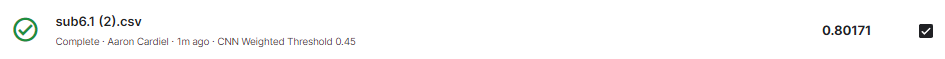

<a name="Results"></a>
# **Final Results**

| Model       | Version | Train Accuracy | Val Accuracy | Test F1 Score |
| :-:         | :-      | :-:            | :-:          | :-:           |
| Log. Reg.   | 1.0     |      0.8549    |      0.7638  |       0.7821  |
|             | 2.0     |      0.8556    |    0.7607    |               |
|             | 3.0     |        0.8548  |       0.7680 |               |
|             | Fix     |       0.8734   |      0.7771  |               |
| Rand. F.    | 1.0     |        0.9840  |        0.7433|      0.77505  |
|             | 2.0     |          0.9841|       0.7593 |               |
| Rand. F.    | LK      |    0.9049      |    0.7577    |    0.78976    |
|             | RBF     |      0.9531    |    0.7587    |               |
| Naïve Bayes | Multi   |      0.8633    |     0.7429   |     0.79098   |
|             | Bern    |      0.8693    |     0.7529   |               |
|             | Comp    |      0.8671    |     0.7469   |               |
| CNN         | (1-Hot) |     0.8512     |      0.7169  |       0.79098 |
|             |(W. Loss)|       0.8801   |       0.7465 |        0.80171|



<a name="Conclusion"></a>
# ***Conclusion***

In this project, we explored six different machine learning models to classify tweets related to disasters. We trained the models on a dataset that consisted of text, keyword, and location features. The six models that we used were Logistic Regression, Random Forest, Support Vector Machines, Naive Bayes, Convolutional Neural Network (1-Hot encoding for Keyword and Location), and Convolutional Neural Network (Weighted Location and Keyword).

Logistic Regression is a simple and fast algorithm used to predict binary outcomes. Random Forest is a popular ensemble learning method that combines multiple decision trees to improve accuracy. Support Vector Machines are a powerful algorithm that can efficiently classify data with complex boundaries. Naive Bayes is a probabilistic algorithm that makes assumptions about the independence of features.

We used Convolutional Neural Networks (CNNs) to classify tweets based on their text, keyword, and location features. The first CNN model used one-hot encoding for location and keyword, which provided a sparse representation of the data. The second CNN model used weighted representations for location and keyword, which improved the performance of the model by providing more informative features.

After comparing the performance of all six models, we found that the CNN with weighted location and keyword representations achieved the highest accuracy. This model was able to identify disaster-related tweets with an f1 accuracy of over 80%, outperforming the other models. The weighted representation of location and keyword allowed the model to capture more meaningful features and improve its ability to classify disaster-related tweets.

Overall, our results demonstrate that using a combination of text, keyword, and location features can improve the accuracy of disaster classification models. The CNN with weighted location and keyword representations was the most effective model, and its performance can be further improved by optimizing the hyperparameters and exploring additional features.